# Using CNN to study the Ising model phase transitions

This notebook is based on the paper **[Machine learning phases of matter][ml]**. However, most of the visualizations found in the end was based on **[Grad-CAM][viz2]** and **[?]**


[ml]:http://dx.doi.org/10.1038/nphys4035
[viz2]:https://doi.org/10.1109/ICCV.2017.74

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle,os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras import regularizers, optimizers
from keras.callbacks import ModelCheckpoint 
import sys, os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Using TensorFlow backend.


#### Parameters plot 

In [2]:
#plt.rcParams['figure.figsize'] = [6.32, 5.11]
#plt.rcParams['figure.constrained_layout.use'] = True

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.labelpad'] = 15

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.major.width'] = 3

plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.major.width'] = 3

plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.markerscale'] = 1

plt.rcParams['lines.markersize'] = 9
plt.rcParams['lines.linewidth'] = 2

In [3]:
path = '../Data/'
dataset_name = 'Ising2DFM_reSample_L40_T=All.pkl'
dataset_label_name = 'Ising2DFM_reSample_L40_T=All_labels.pkl'

In [4]:
# Lattice size.
L = 40

# Temperatures values.
temp_val = np.arange(0.25, 4.0001, 0.25)

# Number of samples simulated in each temperature.
temp_samples = 10000

# Total number o samples.
total_samples = temp_samples * temp_val.shape[0]

# Dataset test size.
test_size = 0.1

# Dataset validattion size.
val_size = 0.2

In [5]:
# Use or not samples from the critical region. (False == use)
split_tc = False

In [6]:
# Loading the dataset.
data = pickle.load(open(path + dataset_name,'rb'))
data = np.unpackbits(data).reshape(-1, L * L).astype(float)

# This dataset has values 0 or 1, but Ising model has values -1 and 1.
data[np.where(data==0)]=-1

# Loading the dataset labels.
labels = pickle.load(open(path + dataset_label_name,'rb'))

In [7]:
# First and last index where the critical temperature region starts and end.
first_tc = np.where(temp_val <= 2.)[0][-1] * temp_samples
last_tc = np.where(temp_val >= 3.)[0][1] * temp_samples

In [8]:
# Build temperatures labels for every sample.
temp_labels = np.hstack([np.repeat(temp, temp_samples) for temp in temp_val])

In [9]:
# Split or not the dataset critical region.

if split_tc:
    
    X_ordered = data[:first_tc, :]
    Y_ordered = np.column_stack((labels[:first_tc], temp_labels[:first_tc]))

    X_critical = data[first_tc:last_tc, :]
    Y_critical = np.column_stack((labels[first_tc:last_tc], temp_labels[first_tc:last_tc]))

    X_disordered = data[last_tc:, :]
    Y_disordered = np.column_stack((labels[last_tc:], temp_labels[last_tc:]))

    X = np.concatenate((X_ordered, X_disordered))
    Y = np.concatenate((Y_ordered, Y_disordered))
    
    del X_ordered, Y_ordered, X_disordered, Y_disordered, data, labels
    
else:
    
    X = data
    Y = np.column_stack((labels, temp_labels))
    
    del data, labels

In [10]:
# Split train, test and validation.

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=val_size)

del X, Y

In [11]:
# Reshape all array (L*L) in images (L,L).

X_train = np.reshape(X_train, (X_train.shape[0], L, L, 1))
X_test = np.reshape(X_test, (X_test.shape[0], L, L, 1))
X_val = np.reshape(X_val, (X_val.shape[0], L, L, 1))

In [12]:
# Creat the model.

model = Sequential()

model.add(Conv2D(filters=3, kernel_size=(3, 3), activation='tanh', input_shape=(L, L, 1)))

#model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Conv2D(filters=20, kernel_size=(3, 3), activation='relu'))

#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

#model.add(Dense(10, activation='relu'))
          
model.add(Dropout(0.5))
          
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 38, 3)         30        
_________________________________________________________________
flatten_1 (Flatten)          (None, 4332)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4332)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4333      
Total params: 4,363
Trainable params: 4,363
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Train the model.
history = model.fit(X_train, Y_train[:, 0], validation_split=0.1, batch_size=128, epochs=3)


Train on 103680 samples, validate on 11520 samples
Epoch 1/3
103680/103680 [==============================] - 5s 45us/step - loss: 0.3105 - accuracy: 0.8449 - val_loss: 0.0146 - val_accuracy: 0.9983
Epoch 2/3
103680/103680 [==============================] - 4s 35us/step - loss: 0.0189 - accuracy: 0.9937 - val_loss: 0.0075 - val_accuracy: 0.9980
Epoch 3/3
103680/103680 [==============================] - 4s 36us/step - loss: 0.0127 - accuracy: 0.9955 - val_loss: 0.0045 - val_accuracy: 0.9988


In [15]:
# Calculate test scores.
score = model.evaluate(X_test, Y_test[:, 0], verbose=0)
print('Test accuracy: {1:6.4f} \nTest loss: {0:6.4f}'.format(score[0], score[1]))

Test accuracy: 0.9984 
Test loss: 0.0057


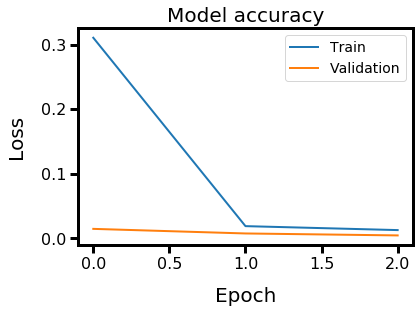

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

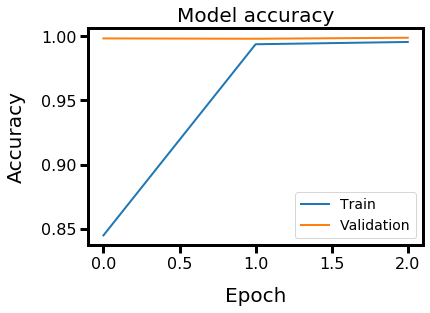

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [18]:
# Get datast test predictions.
res_test = model.predict(X_test)

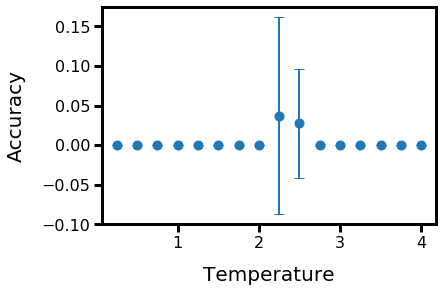

In [19]:
# Accuracy plot for every temperature.

acc = np.zeros(temp_val.shape[0])
acc_std = np.zeros(temp_val.shape[0])

for idx, temp in enumerate(temp_val):
    
    
    pos = np.argwhere(Y_test[:, 1] == temp)[:, 0]
    
    aux = res_test[pos, 0] - Y_test[pos, 0]
    acc[idx] = np.mean(np.abs(aux))
    acc_std[idx] = np.std(np.abs(aux))

    
    
plt.errorbar(x=temp_val, y=acc,
             yerr=acc_std, fmt='o', capsize=5)

plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.show()

### adicionar comentários.

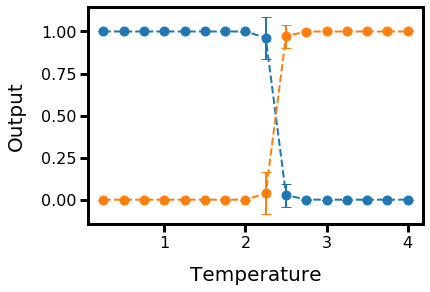

In [20]:
# Output value plot for every temperature.

#%matplotlib notebook
output_mean = np.zeros(temp_val.shape[0])
output_std = np.zeros(temp_val.shape[0])

for idx, temp in enumerate(temp_val):
    
       
    pos = np.argwhere(Y_test[:, 1] == temp)[:, 0]
    
    output_mean[idx] = np.mean(res_test[pos])
    output_std[idx] = np.std(res_test[pos])
    
plt.errorbar(x=temp_val, y=output_mean, yerr=output_std,
             fmt='o', capsize=5, linestyle='--')

plt.errorbar(x=temp_val, y=np.abs(output_mean - 1),
             yerr=output_std, fmt='o', capsize=5, linestyle='--')

plt.ylabel('Output')
plt.xlabel('Temperature')
plt.show()

### adicionar comentários.

## CNN's kernels

In [21]:
# Get filters values
filters, biases = model.layers[0].get_weights()
filters_number = filters.shape[-1]

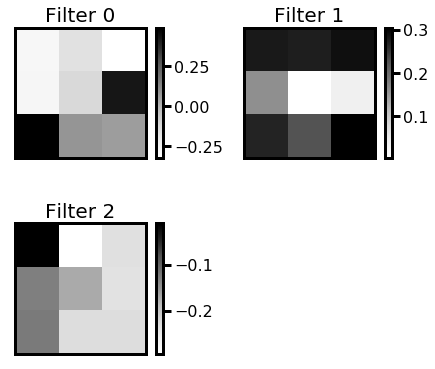

In [22]:
# Filters plot.
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(filters_number, figsize=[9,6])

for idx in range(filters_number):
    
    f = filters[:, :, 0, idx]
    
    axis = plt.subplot(2, 2, idx+1)
    axis.set_xticks([])
    axis.set_yticks([])
    mp = axis.imshow(f, cmap='Greys')
    plt.title('Filter ' + str(idx))
    fig.colorbar(mp, ax=axis)
    
plt.subplots_adjust(right=0.8, hspace=0.5, wspace=0.1)
plt.show()

In [23]:
from keras.models import Model

# Get the first conv layer
layer = model.layers[0]

# Create a new model that receives a input with shape (40,40,1) and output
# conv layer results.
model_output = Model(inputs=model.inputs, outputs=layer.output)

In [24]:
# Get predictions using the new model.
predict = model_output.predict(X_test)

In [25]:
# Indexs for critical, ordered and disordered regions.
critical_id = np.where(Y_test==2.25)[0]
ordered_id = np.where(Y_test==1.)[0]
disordered_id = np.where(Y_test==4.)[0]

In [26]:
def kernels_plot(filters_number, pred):
    
    fig, ax = plt.subplots(filters_number, figsize=[9, 6])

    for f_idx in range(filters_number):
    
        f = pred[:, :, f_idx]
    
        axis = plt.subplot(2, 2, f_idx+1)
        axis.set_xticks([])
        axis.set_yticks([])
        mp = axis.imshow(f, origin='lower', cmap='bone') #bone, copper, hot, afmhot
        plt.title('Filter ' + str(idx))
        fig.colorbar(mp, ax=axis)
    
    fig.subplots_adjust(right=0.8, hspace=0.5, wspace=0.1)
    plt.show()

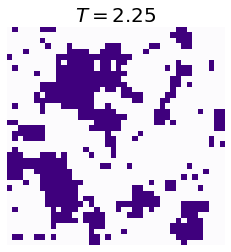

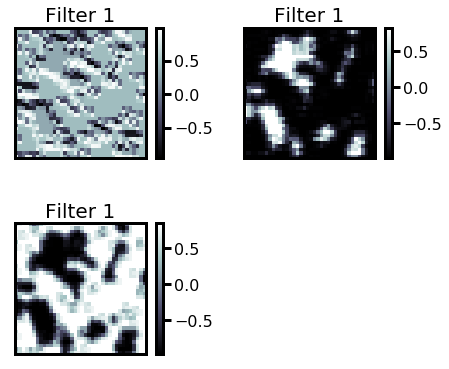

In [27]:
# Filters activations for a sample at critical region.

# Index of critical samples.
idx = 1

plt.imshow(X_test[critical_id[idx], : , :, 0], origin='lower', cmap='Purples')
plt.axis(False)
plt.title(r'$T= $' + str(Y_test[critical_id[idx], 1]))
plt.show()

kernels_plot(filters_number, predict[critical_id[idx], :, :, :])

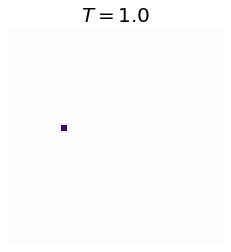

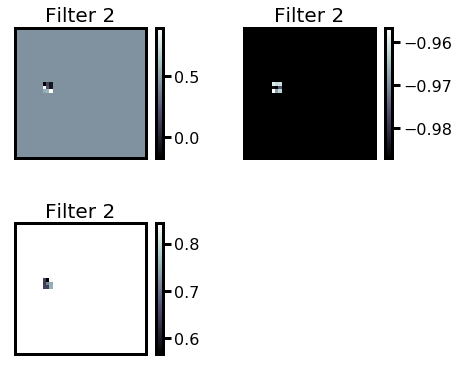

In [28]:
# Filters activations for a sample at critical region.

# Index for ordered samples.
idx = 2

plt.imshow(X_test[ordered_id[idx], : , :, 0], origin='lower', cmap='Purples')
plt.axis(False)
plt.title(r'$T= $' + str(Y_test[ordered_id[idx], 1]))
plt.show()

kernels_plot(filters_number, predict[ordered_id[idx], :, :, :])

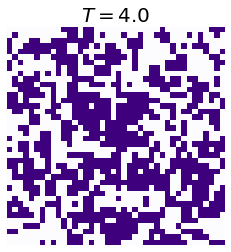

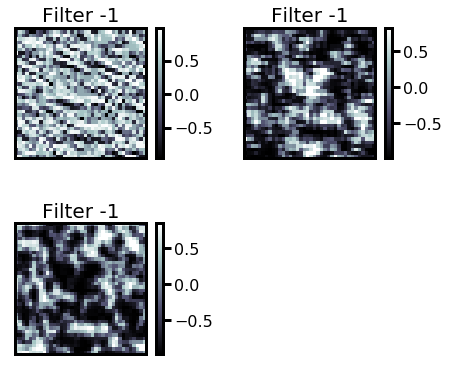

In [29]:
# Filters activations for a sample at critical region.

# Index for ordered samples.
idx = -1

plt.imshow(X_test[disordered_id[idx], : , :, 0], origin='lower', cmap='Purples')
plt.axis(False)
plt.title(r'$T= $' + str(Y_test[disordered_id[idx], 1]))
plt.show()

kernels_plot(filters_number, predict[disordered_id[idx], :, :, :])

## What CNN is seen

In [103]:
import keras.backend as K
import cv2
import seaborn as sns

In [149]:
def Grad_CAM(model_input, class_output, last_conv_layer_output, img, x, L):
    
    grads = K.gradients(class_output, last_conv_layer_output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model_input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    for i in range(conv_layer_output_value.shape[-1]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    
    if np.max(heatmap) != 0.0:
        heatmap /= np.max(heatmap)
    
    heatmap = cv2.resize(heatmap, (L, L))
    heatmap = np.uint8(255 * heatmap)
    img = np.uint8(255 * img)
    
    aux = cv2.GaussianBlur(heatmap,(5,5),0) * 0.6 + img * 0.4
    
    plt.figure(figsize=[9,9])
    
    ax = plt.subplot(121)
    ax.imshow(aux, origin='lower', cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    ax = plt.subplot(122)
    
    ax.imshow(img, origin='lower', cmap='Purples')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

CNN prediction:  0.99 
True label:  1.00


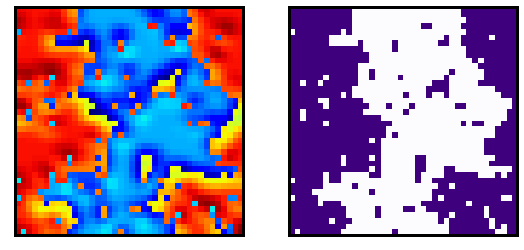

In [151]:
# Critical region.

idx = critical_id[5]

x = np.reshape(X_test[idx], (1, L, L , 1))
img = x[0,:,:,0]

pred_c = model.predict(x)
print('CNN prediction: {0:5.2f} \nTrue label: {1:5.2f}'.format(pred_c[0][0], Y_test[idx, 0]))

class_output = model.output[:, 0]
last_conv_layer = model.get_layer('conv2d_1')

Grad_CAM(model.input, class_output, last_conv_layer.output, img, x, L)

CNN prediction:  1.00 
True label:  1.00


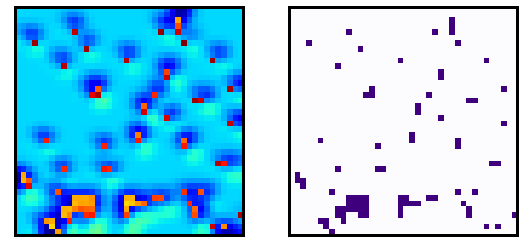

In [95]:
# Ordered region.

idx = ordered_id[5]

x = np.reshape(X_test[idx], (1, L, L , 1))
img = x[0,:,:,0]

pred_c = model.predict(x)
print('CNN prediction: {0:5.2f} \nTrue label: {1:5.2f}'.format(pred_c[0][0], Y_test[idx, 0]))

Grad_CAM(model.input, class_output, last_conv_layer.output, img, x, L)

CNN prediction:  0.00 
True label:  0.00


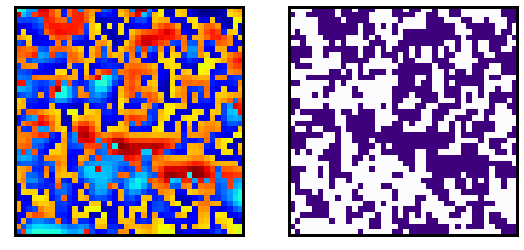

In [96]:
# Disordered region.

idx = disordered_id[5]

x = np.reshape(X_test[idx], (1, L, L , 1))
img = x[0,:,:,0]

pred_c = model.predict(x)
print('CNN prediction: {0:5.2f} \nTrue label: {1:5.2f}'.format(pred_c[0][0], Y_test[idx, 0]))

Grad_CAM(model.input, class_output, last_conv_layer.output, img, x, L)

In [152]:
#quit()